In [2]:
from typing import Dict
import seaborn as sns
import os, json
import pandas as pd
import numpy as np
from tqdm import tqdm
from loguru import logger
from os.path import join as pjoin
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
from matplotlib import colors

# Constants

In [3]:
GROUP_LIST = [
    "Humans",
    "glm-4v-9b",
    "gemini-1.5-pro",
    "gpt-4o",
    "Qwen2.5-VL-72B-Instruct",
    "internlm-xcomposer2-vl-7b",
]
GROUP_LIST3 = [
    "Humans",
    "glm-4v-9b",
    "gemini-1.5-pro",
    "gpt-4o",
    "Qwen2.5-VL-72B-Instruct",
    "internlm-xcomposer2-vl-7b",
    "Llama-3.2V-11B-cot", # this is not used for analysis due to its low accuracy
] # ones that have 11 runs per stimulus
api_to_name = {"Humans": "Humans", "gemini-1.5-pro": "Gemini", "gpt-4o": "GPT", "Qwen2.5-VL-72B-Instruct": "Qwen", "internlm-xcomposer2-vl-7b": "InternLM", "glm-4v-9b": "GLM"}

VLM_LIST = []
VLM_TIME = {}
VLM_TIME_PATH = pjoin('model_info', "model_metadata.json")
VLM_SIZE = {
    # from hugging face
    "WeMM-Chat-2k-CN": 9.47,
    "WeMM-Chat-CN": 8.8,
    # from eval team
    "Chat-UniVi": 7.5,
    "Llama-3-MixSenseV1_1": 8,
    "Monkey-Chat": 7,
    "emu2-chat": 37,
    "emu3-chat": 8.49,
    "moondream1": 1.6,
    "moondream2": 1.93,
    # from https://epoch.ai/data/large_scale_ai_models.csv
    "Aria": 25.3,
    "MiniGPT_4_V2": 7.0,
    "MiniMonkey": 2.0,
    "Monkey": 9.7,
    "Phi-4-multimodal-instruct": 5.6,
    "TransCore-M": 13.0,
    "WeMM": 10.0,
    "deepseek-vl2": 4.5,
    "deepseek-vl2-small": 2.8,
    "deepseek-vl2-tiny": 1.0,
    "instructblip-flan-t5-xl": 3.0,
    "instructblip-flan-t5-xxl": 11.0,
    # from names
    '360VL-70B': 70.0, 'Aquila-VL-2B-llava-qwen': 2.0, 'Chat-UniVi-13B': 13.0, 'InternVL2_5-1B': 1.0, 'InternVL2_5-26B': 26.0, 'InternVL2_5-2B': 2.0, 'InternVL2_5-38B': 38.0, 'InternVL2_5-4B': 4.0, 'InternVL2_5-8B': 8.0, 'Janus-1.3B': 1.3, 'Janus-Pro-1B': 1.0, 'Janus-Pro-7B': 7.0, 'JanusFlow-1.3B': 1.3, 'LLaVA-NeXT-Video-32B-Qwen': 32.0, 'LLaVA-Video-72B-Qwen2': 72.0, 'Llama-3-LongVILA-8B-1024Frames': 8.0, 'Llama-3-LongVILA-8B-128Frames': 8.0, 'Llama-3-LongVILA-8B-256Frames': 8.0, 'Llama-3-LongVILA-8B-512Frames': 8.0, 'Llama-3-VILA1.5-8B': 8.0, 'Llama-3-VILA1.5-8B-Fix': 8.0, 'Llama-3.2-11B-Vision-Instruct': 11.0, 'Llama-3.2-90B-Vision-Instruct': 90.0, 'Llama-3.2V-11B-cot': 11.0, 'MGM-7B-HD': 7.0, 'Molmo-72B-0924': 72.0, 'Molmo-7B-D-0924': 7.0, 'Molmo-7B-O-0924': 7.0, 'MolmoE-1B-0924': 1.0, 'NVLM-D-72B': 72.0, 'OmniLMM-12B': 12.0, 'OpenFlamingo-9B-vitl-mpt7b': 9.0, 'Parrot-14B': 14.0, 'Parrot-7B': 7.0, 'Pixtral-12B-2409': 12.0, 'Qwen2.5-VL-3B-Instruct': 3.0, 'Qwen2.5-VL-72B-Instruct': 72.0, 'Qwen2.5-VL-7B-Instruct': 7.0, 'VILA1.5-13B': 13.0, 'VILA1.5-3B': 3.0, 'VILA1.5-3B-s2': 3.0, 'VILA1.5-40B': 40.0, 'Video-LLaVA-7B': 7.0, 'VideoChat2_HD_stage4_Mistral_7B_hf': 7.0, 'VideoChat2_stage3_Mistral_7B': 7.0, 'VideoLLaMA2-72B': 72.0, 'VideoLLaMA2-7B': 7.0, 'VideoLLaMA2-7B-16F': 7.0, 'VideoLLaMA2.1-7B-16F': 7.0, 'XVERSE-V-13B': 13.0, 'Yi-VL-34B': 34.0, 'Yi-VL-6B': 6.0, 'blip2-flan-t5-xl': 3.0, 'blip2-flan-t5-xxl': 11.0, 'blip2-opt-2.7b': 2.7, 'blip2-opt-6.7b': 6.7, 'deepseek-vl-1.3b-chat': 1.3, 'deepseek-vl-7b-chat': 7.0, 'falcon-11B-vlm': 11.0, 'fuyu-8b': 8.0, 'gemma-3-12b-it': 12.0, 'gemma-3-27b-it': 27.0, 'gemma-3-4b-it': 4.0, 'glm-4v-9b': 9.0, 'instructblip-vicuna-13b': 13.0, 'instructblip-vicuna-7b': 7.0, 'internlm-xcomposer2-4khd-7b': 7.0, 'internlm-xcomposer2-7b': 7.0, 'internlm-xcomposer2-vl-1_8b': 8, 'internlm-xcomposer2-vl-7b': 7.0, 'internlm-xcomposer2d5-7b': 7.0, 'llava-onevision-qwen2-0.5b-ov-hf': 0.5, 'llava-onevision-qwen2-0.5b-si-hf': 0.5, 'llava-onevision-qwen2-72b-ov-chat-hf': 72.0, 'llava-onevision-qwen2-72b-ov-hf': 72.0, 'llava-onevision-qwen2-72b-si-hf': 72.0, 'llava-onevision-qwen2-7b-ov-chat-hf': 7.0, 'llava-onevision-qwen2-7b-ov-hf': 7.0, 'llava-onevision-qwen2-7b-si-hf': 7.0, 'mplug-owl2-llama2-7b': 7.0, 'paligemma-3b-mix-448': 3.0, 'video_chat_13b': 13.0, 'video_chat_7b': 7.0, 'video_chatgpt-7B': 7.0, 'visualglm-6b': 6.0
}

# Styles

In [ ]:
colors = ["#B83945", "#377483", "#E3E457", "#DAA87C", "#D9B9D4", "#C9DCC4", "#C5DFF4", "#7C9895", "#F4EEAC", "#AEB2D1", "#4F845C", "#92A5D1"] # https://www.xiaohongshu.com/explore/65c0b9f9000000000a030e41
color_N = len(colors[3:10]) - 1
cmap_colors = []
for color in colors[3:10]:
    if color == colors[7]: continue
    # For Accuracy=0: lighter shade (mix with white)
    lighter = np.array([1, 1, 1]) * 0.5 + np.array([int(color[1:3], 16)/255, 
                                                    int(color[3:5], 16)/255, 
                                                    int(color[5:7], 16)/255]) * 0.5
    # For Accuracy=1: original color
    darker = np.array([int(color[1:3], 16)/255, int(color[3:5], 16)/255, int(color[5:7], 16)/255])
    cmap_colors.extend([lighter, darker])

USE_TEX = False
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18
def config_plot_style(font_family: str = "serif"):
    # https://jwalton.info/Embed-Publication-Matplotlib-Latex/
    tex_fonts = {
        "text.usetex": USE_TEX, # Use LaTeX to write all text
        "font.family": font_family,
        "axes.titlesize": SMALL_SIZE,   # fontsize of the axes title
        "axes.labelsize": MEDIUM_SIZE,  # fontsize of the x and y labels
        "font.size": SMALL_SIZE,        # controls default text sizes
        "legend.fontsize": MEDIUM_SIZE,  # legend fontsize
        "xtick.labelsize": SMALL_SIZE,  # fontsize of the tick labels
        "ytick.labelsize": SMALL_SIZE,  # fontsize of the tick labels
        "figure.titlesize": BIGGER_SIZE,# fontsize of the figure title
    }
    #sns.set_theme(rc={'text.usetex' : USE_TEX}) # this needs to be set before the matplotlib
    #plt.rcParams.update(tex_fonts)

config_plot_style()

# Helper functions

In [5]:
def map_participant_id(result_df: pd.DataFrame) -> Dict[str, str]:
    """
    Find the shortest prefix of participant_id that can uniquely identify each participant.
    Return a mapping from the original participant_id to the new one.
    """
    result_df = result_df[result_df['GroupKind'] == 'Humans'].copy()
    unique_participants = result_df['Participant_ID'].unique()
    
    length = 1
    while True:
        prefix_mapping = {pid[-length:]: pid for pid in unique_participants}
        if len(prefix_mapping) == len(unique_participants):
            return {pid: prefix for prefix, pid in prefix_mapping.items()}
        
        length += 1

def map_stimulus_id(stimuli_df: pd.DataFrame) -> Dict[int, int]:
    """
    Map Stimulus_ID to a new ID based on one that is sorted by Proximity, then Angle.
    """
    stimuli_df = stimuli_df[stimuli_df["list_id"] != -1] # filter out attentional checks
    stimuli_df = stimuli_df.sort_values(["n_candidates", "Proximity", "Angle"], kind='stable')
    stimulus_mapping = {old_id: new_id for new_id, old_id in enumerate(stimuli_df["Stimulus_ID"].unique())}
    return stimulus_mapping

def get_baseline(stimuli_df: pd.DataFrame):
    return np.mean(1 / stimuli_df["n_candidates"])

# Load stimuli sheet and responses

In [6]:
result_df = pd.read_csv('result_1743457603_20250506_20250506F.csv')
stimuli_df = pd.read_csv('stimuli_1743457603.csv')

stimuli_df["Proximity"] = 4 - stimuli_df["Proximity"] # flip, since in the stimuli sheet, 3 means farther away; we want 3 to mean closer
stimuli_df["Formatted_Candidates"] = stimuli_df.apply(lambda row: f"{row['n_candidates']} objects ({row['Actor']})", axis=1)
stimuli_df["Formatted_Candidates_Full"] = stimuli_df.apply(lambda row: f"{row['Candidates']} ({row['Actor']})", axis=1)
stimuli_df = stimuli_df[stimuli_df["list_id"] != -1] # filter out attentional checks

result_df["Formatted_Candidates"] = result_df.apply(lambda row: f"{row['n_candidates']} objects ({row['Actor']})", axis=1)
result_df["Formatted_Candidates_Full"] = result_df.apply(lambda row: f"{row['Candidates']} ({row['Actor']})", axis=1)
result_df = result_df[result_df["list_id"] != -1] # filter out attentional checks

VLM_LIST = sorted(result_df['Group'].unique().tolist())
VLM_LIST.remove('Humans')

with open(VLM_TIME_PATH, "r", encoding="utf-8") as f: json_data = json.load(f)
VLM_TIME = {k: v['last_modified'] for k, v in json_data.items() if 'last_modified' in v} | {k: v['created_at'] for k, v in json_data.items() if 'last_modified' not in v}

sorted_candidates = stimuli_df.sort_values(["n_candidates", "Actor"])["Formatted_Candidates"].unique().tolist()
sorted_candidates_full = stimuli_df.sort_values(["n_candidates", "Actor"])["Formatted_Candidates_Full"].unique().tolist()

pid_mapping = map_participant_id(result_df)
sid_mapping = map_stimulus_id(stimuli_df)

# Plots
Figures are displayed in the same order as in the paper.

ranking_time: 75 VLMs.
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.014    
Dependent Variable: Accuracy         AIC:                -286.1808
Date:               2025-05-22 20:03 BIC:                -281.5458
No. Observations:   75               Log-Likelihood:     145.09   
Df Model:           1                F-statistic:        2.071    
Df Residuals:       73               Prob (F-statistic): 0.154    
R-squared:          0.028            Scale:              0.0012559
-------------------------------------------------------------------
                 Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
-------------------------------------------------------------------
const            0.4113    0.0132  31.1663  0.0000   0.3850  0.4376
TimeNumeric      0.0000    0.0000   1.4390  0.1544  -0.0000  0.0001
------------------------------------------------------------------
Omnibus:              45.685       Durbin-Watson:   

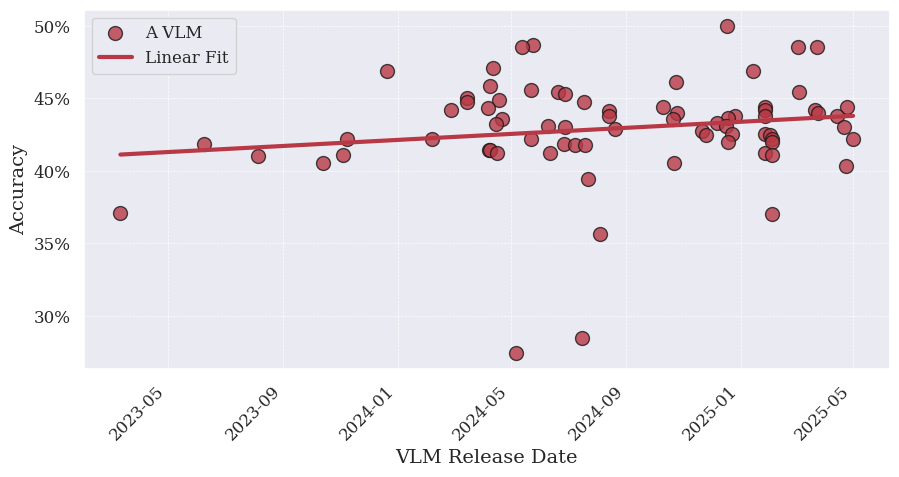

In [7]:
mean_df = result_df[ (result_df["Part"] == 'p0') ].groupby(["Group"])['Accuracy'].mean().reset_index()
mean_df = mean_df.sort_values(by=["Accuracy"], ascending=False)
plt.figure(figsize=(10, 5))
plt.tick_params(axis='both', which='major', labelsize=12)
mean_df = mean_df[mean_df["Group"].isin(VLM_TIME.keys())]
print(f"ranking_time: {len(mean_df)} VLMs.")
mean_df['Model-time-str'] = list(map(lambda name: VLM_TIME[name], mean_df['Group']))
mean_df['Model-time'] = pd.to_datetime(mean_df['Model-time-str'], format='%Y-%m-%d', exact=True)
#mean_df = mean_df.sort_values(by='Model-time')
plt.scatter(mean_df['Model-time'], mean_df['Accuracy'], color=colors[0], label='A VLM', s=100, alpha=0.8, edgecolors='k')

mean_df['TimeNumeric'] = (mean_df['Model-time'] - mean_df['Model-time'].min()).dt.days
X = mean_df[['TimeNumeric']]
y = mean_df['Accuracy']
X_ols = add_constant(X)
mod = sm.OLS(y, X_ols) # Use X_ols with constant
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
print(fii.summary2(), '\n\nP-value:', p_values )

time_range_numeric = np.linspace(mean_df['TimeNumeric'].min(), mean_df['TimeNumeric'].max())
time_range_numeric_ols = add_constant(time_range_numeric.reshape(-1, 1))
y_pred_ols = fii.predict(time_range_numeric_ols)
time_range_dates = pd.to_datetime(mean_df['Model-time'].min() + pd.to_timedelta(time_range_numeric, unit='D'))
plt.plot(time_range_dates, y_pred_ols, color=colors[0], linestyle='-', linewidth=3, label='Linear Fit')

plt.xlabel('VLM Release Date', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4)) # Show a tick every 3 months, adjust as needed
plt.xticks(rotation=45, ha='right') # Rotate labels for better readability

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y * 100:.0f}%"))
plt.legend(fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.subplots_adjust(left=0.164, bottom=0.231, right=0.97, top=0.95, wspace=0.09, hspace=0.211)

/Users/zory/miniforge3/envs/py310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/zory/miniforge3/envs/py310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


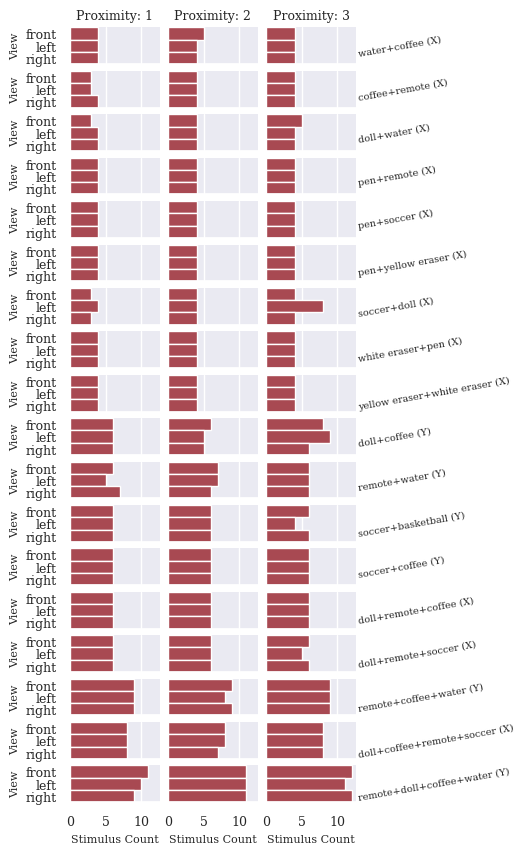

In [13]:
count_df = stimuli_df.groupby(["Formatted_Candidates_Full", "Angle", "Proximity"]).size().reset_index(name="Count")
g = sns.FacetGrid(count_df, row="Formatted_Candidates_Full", row_order=sorted_candidates_full, col="Proximity", margin_titles=True, height=0.473, aspect=3.6)
g.map_dataframe(sns.barplot, y="Angle", x="Count", order=["front", "left", "right"], orient="h", width=1, color=colors[0])
g.tick_params(axis='both', which='major', labelsize=9)
g.set_axis_labels("Stimulus Count", "View", fontsize=8)
g.set_titles(row_template="", col_template="Proximity: {col_name}", size=9)
for ax, row_name in zip(g.axes[:, 2], g.row_names):
    ax.annotate(
        row_name,
        xy=(1.02, 0.5),
        xycoords='axes fraction',
        ha='left',
        va='center',
        fontsize=7,
        rotation=10
    )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    
plt.subplots_adjust(left=0.13, bottom=0.053, right=0.69, top=0.963, wspace=0.092, hspace=0.18)

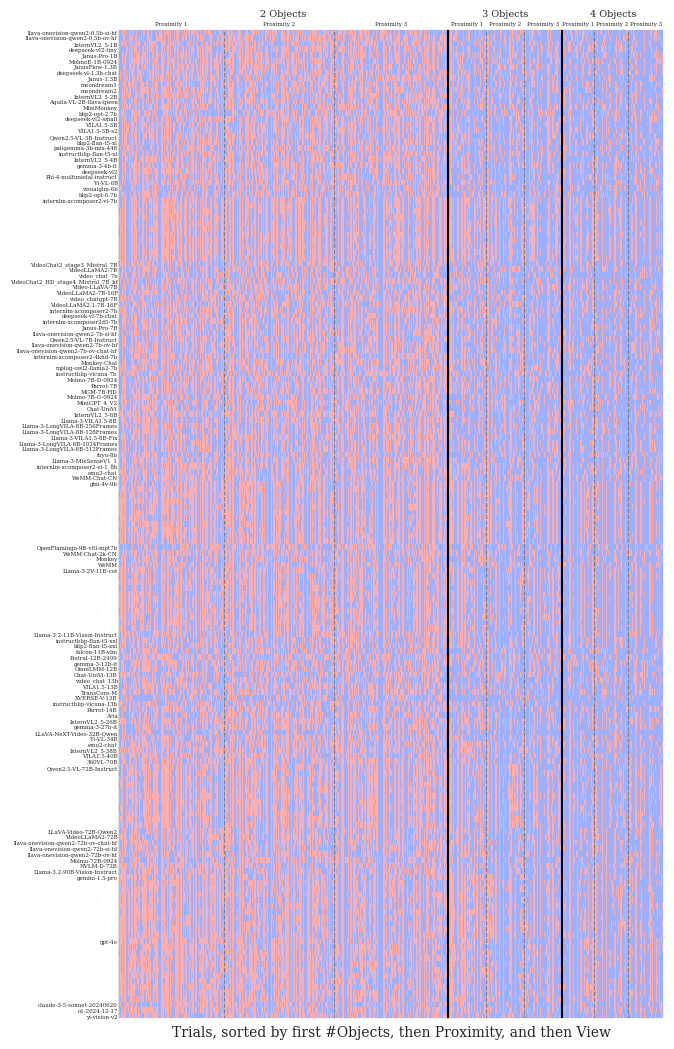

In [14]:
# ===== Pre-allocate arrays with efficient data types =====
# Since accuracy is binary (0/1), use int8 instead of float64
group_list_vlms = GROUP_LIST3.copy()
group_list_vlms.remove("Humans")
other_vlms = [vlm for vlm in result_df['Group'].unique() if vlm not in GROUP_LIST3]
n_stimuli = result_df['Stimulus_ID'].nunique()
n_rows = len(other_vlms)
for group in group_list_vlms:
    n_rows += int(np.ceil(len(result_df[result_df['Group'] == group])/ n_stimuli))
all_groups = sorted(group_list_vlms + other_vlms, key=lambda x: VLM_SIZE.get(x, 9999))

data_matrix = np.zeros((n_rows, n_stimuli), dtype=np.int8)
row_labels = [""] * n_rows
vlm_indices = np.zeros(n_rows, dtype=np.int8)

# ===== Construct data_matrix =====
row_idx_start = 0
for vlm_idx, group in enumerate(all_groups):
    vlm_df = result_df[result_df['Group'] == group]
    n_appear = np.zeros(result_df['Stimulus_ID'].max() + 1, dtype=int)
    
    for _, row_data in vlm_df.iterrows():
        stimulus_id = row_data['Stimulus_ID']
        row_idx = row_idx_start + n_appear[stimulus_id]
        data_matrix[row_idx, sid_mapping[stimulus_id]] = int(row_data['Accuracy'])
        n_appear[stimulus_id] += 1
        
        # Store metadata
        if row_idx == row_idx_start:
            row_labels[row_idx] = group
            vlm_indices[row_idx] = vlm_idx
        
    row_idx_start += n_appear.max()
assert row_idx_start == n_rows

# ===== Create the heatmap =====
fig, ax = plt.subplots(figsize=(7, 11)) # textheight=9inch, width=5.5inch -> 7x11.45
cmap = plt.cm.berlin.copy()
cmap.set_bad('white', 1.0)
#masked_data = np.ma.masked_array(data_matrix, data_matrix < 0) # Mark -1 values as masked
ax.imshow(data_matrix, cmap=cmap, aspect='auto', interpolation='nearest')

# Set y-axis labels with colors based on VLM index
ax.set_yticklabels([])  # Hide default y labels
for i, label in enumerate(row_labels):
    if label != "":
        ax.text(-1, i, label, fontsize=4, va='center', ha='right')

# Add gridlines and labels for #Candidates and Proximity zones
candidates_proximity = stimuli_df.groupby(['n_candidates', 'Proximity'])['Stimulus_ID'].first().reset_index()
gridline_positions_candidates = []
gridline_positions_proximity = []
candidate_labels = []
proximity_labels = []
last_candidate = None

for _, row in candidates_proximity.iterrows():
    current_candidate = row['n_candidates']
    current_proximity = row['Proximity']
    stimulus_id = sid_mapping[row['Stimulus_ID']]

    # Add gridline for new #Candidates
    if current_candidate != last_candidate:
        gridline_positions_candidates.append(stimulus_id - 0.5)
        candidate_labels.append((stimulus_id, f"{current_candidate} Objects"))
        last_candidate = current_candidate

    # Add gridline for new Proximity within the same #Candidates
    gridline_positions_proximity.append(stimulus_id - 0.5)
    proximity_labels.append((stimulus_id, f"Proximity {current_proximity}"))

# Draw gridlines for #Candidates
for i, pos in enumerate(gridline_positions_candidates):
    ax.axvline(pos, color='black', linestyle='-', linewidth=1.5)

# Draw gridlines for Proximity
for pos in gridline_positions_proximity:
    if pos in gridline_positions_candidates: continue
    ax.axvline(pos, color='gray', linestyle='--', linewidth=0.8)

# Add labels for #Candidates and Proximity zones
for i in range(len(candidate_labels)):
    if i < len(candidate_labels) - 1:
        start_pos, _ = candidate_labels[i]
        end_pos, _ = candidate_labels[i + 1]
        center_pos = (start_pos + end_pos) / 2
    else:
        # Handle the last label - center it from its position to the end of the plot
        start_pos, _ = candidate_labels[i]
        end_pos = n_stimuli - 0.5  # End of the plot
        center_pos = (start_pos + end_pos) / 2
    
    ax.text(center_pos, -4, candidate_labels[i][1], fontsize=7, ha='center', va='top', rotation=0)

for i in range(len(proximity_labels)):
    if i < len(proximity_labels) - 1:
        start_pos, _ = proximity_labels[i]
        end_pos, _ = proximity_labels[i + 1]
        center_pos = (start_pos + end_pos) / 2
    else:
        # Handle the last label - center it from its position to the end of the plot
        start_pos, _ = proximity_labels[i]
        end_pos = n_stimuli - 0.5  # End of the plot
        center_pos = (start_pos + end_pos) / 2
    
    ax.text(center_pos, -2, proximity_labels[i][1], fontsize=4, ha='center', va='top', rotation=0)
        
ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
#ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='major', visible=False)

# Add x-axis label
ax.set_xticks([])
ax.set_xlabel('Trials, sorted by first #Objects, then Proximity, and then View', fontsize=10)

# Add a legend to explain missing values
#handles = [
#    plt.Rectangle((0, 0), 1, 1, color='white', label='Missing data'),
#    plt.Rectangle((0, 0), 1, 1, color=plt.cm.berlin.reversed()(1.0), label='Correct (1)'),
#    plt.Rectangle((0, 0), 1, 1, color=plt.cm.berlin.reversed()(0.0), label='Incorrect (0)')
#]
#ax.legend(handles=handles, loc='lower right', bbox_to_anchor=(0., 1.02), 
#         ncol=3, frameon=True, fontsize=8)

plt.subplots_adjust(left=0.2, bottom=0.07, right=0.98, top=0.97)

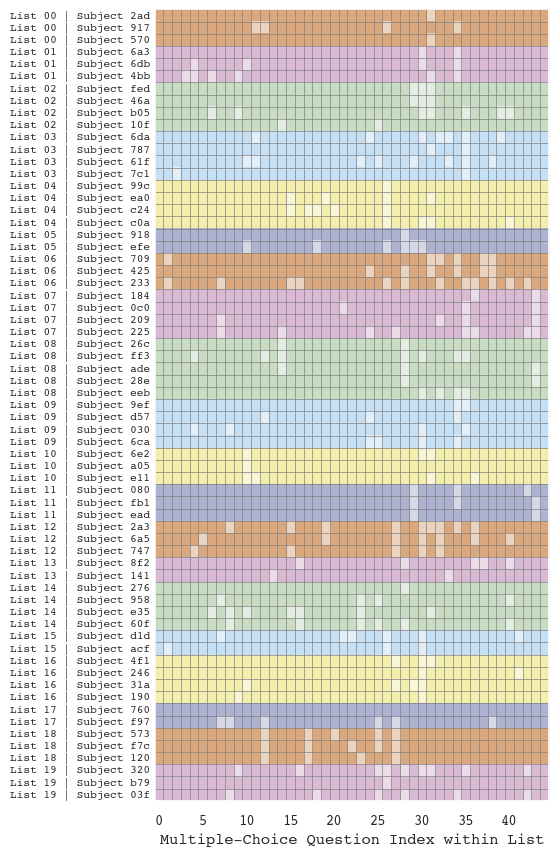

In [15]:
config_plot_style("Courier")
all_rows = []
row_labels = []
list_id_for_rows = []

# Process each list_id
for list_id in sorted(result_df['list_id'].unique()):
    list_df = result_df[(result_df['list_id'] == list_id)]
    
    for participant in pid_mapping.keys():
        participant_df = list_df[list_df['Participant_ID'] == participant]
        if participant_df.empty:
            continue
        if len(participant_df) != 45:
            logger.warning(f"Participant {participant} in list {list_id} has {len(participant_df)} rows, expected 45")
            continue
        
        # sort by Stimulus_ID to ensure the order is correct when there was randomization
        participant_df = participant_df.sort_values(by="Stimulus_ID")
        
        # Add one row to data matrix (45 columns)
        all_rows.append(participant_df["Accuracy"].values)
        # Add row label and list_id for coloring
        row_labels.append(f"List {list_id:02d} | Subject {pid_mapping[participant]}")
        list_id_for_rows.append(list_id)

# Convert to numpy array
data_matrix = np.array(all_rows)

# Normalize data: map (list_id, Accuracy) to colormap indices
# Accuracy=0 -> 2*list_id, Accuracy=1 -> 2*list_id+1
normalized_data = np.zeros_like(data_matrix, dtype=float)
for i, list_id in enumerate(list_id_for_rows):
    normalized_data[i] = 2 * (list_id % color_N) + data_matrix[i]

# Create the heatmap
fig, ax = plt.subplots(figsize=(5.5, 8.5)) # textheight=9inch, width=5.5inch
ax.imshow(normalized_data, cmap=ListedColormap(cmap_colors), aspect='auto', interpolation='nearest')

# Set y-axis labels with colors based on list_id
ax.set_yticks(np.arange(len(row_labels)))
for i, label in enumerate(row_labels):
    color = colors[list_id_for_rows[i] % color_N]
    ax.text(-1, i, label, fontsize=8, va='center', ha='right', fontdict=None)
ax.set_yticklabels([])  # Hide default labels

# Set x-axis labels (items 1 to 45)
#ax.set_xticks(np.arange(45))
#ax.set_xticklabels([f"Item {i+1}" for i in range(45)], rotation=45, ha='right', fontsize=8)

# Add gridlines to align with cells
ax.set_xticks(np.arange(-0.5, 45, 1), minor=True)
ax.tick_params(axis='x', which='both', labelsize=10)  # Set tick label font size to 10
ax.set_yticks(np.arange(-0.5, len(all_rows), 1), minor=True)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='major', visible=False)

# Labels and title
ax.set_xlabel('Multiple-Choice Question Index within List', fontsize=11)
#plt.title('Participant Responses by List and Item')
plt.subplots_adjust(left=0.269, bottom=0.056, right=0.986, top=0.987, wspace=0.2, hspace=0.2)
config_plot_style() # restore default style

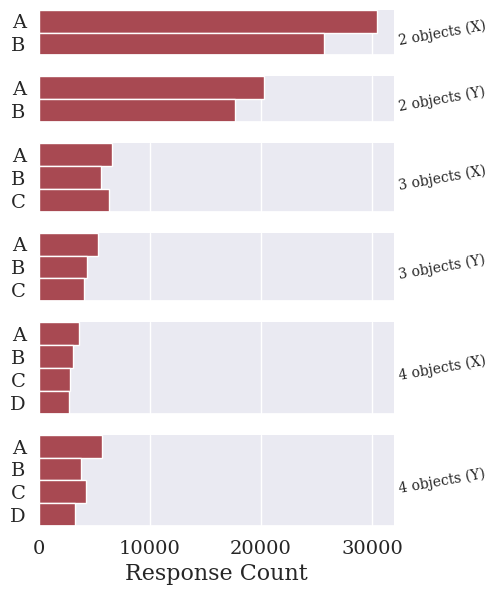

In [16]:
format_column = "Formatted_Candidates"
row_names = sorted_candidates
base_fig_height_per_row = 1
fig_width = 5

count_df = result_df[ result_df['Response'].isin(['A', 'B', 'C', 'D']) ].groupby([format_column, "Response"]).size().reset_index(name="Count")
# --- Step 1: Calculate Heights ---
# Get the number of unique responses for each candidate group
responses_per_candidates = count_df.groupby(format_column)['Response'].nunique()
# Ensure the counts are in the same order as row_names
responses_per_candidates = responses_per_candidates.reindex(row_names)
height_ratios = responses_per_candidates.values

# --- Step 2: Create Subplots ---
n_rows = len(row_names)
# Estimate figure height: e.g., 0.5 inches per expected average response bar + spacing
# This is less critical now ratios control relative height. Adjust figsize width as needed.
total_fig_height = n_rows * base_fig_height_per_row

fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=1,
    sharex=True, # Keep x-axis shared
    figsize=(fig_width, total_fig_height),
    gridspec_kw={'height_ratios': height_ratios} # Key part!
)
if n_rows == 1:
    axes = [axes]

# --- Step 3: Loop and Plot ---
bar_width = 1 # Width/thickness of individual bars (relative to slot height)

for i, ax in enumerate(axes):
    row_name = row_names[i]
    # Filter data for the current candidate
    facet_data = count_df[count_df[format_column] == row_name].copy()

    # Get unique responses *for this facet* to set order and labels
    unique_responses = sorted(facet_data['Response'].unique())

    # Plot directly onto this specific axis (ax)
    sns.barplot(
        x='Count',
        y='Response',
        data=facet_data,
        orient='h',
        order=unique_responses, # Order matters for y-axis labels
        width=bar_width, # Controls bar thickness relative to calculated slot height
        ax=ax,
        color=colors[0],
    )

    # --- Customization per Axis ---
    # Remove y-axis label generated by barplot if desired (we add title later)
    ax.set_ylabel("")
    # Set specific y-ticks and labels (optional but good practice)
    # Barplot usually does this okay with order, but explicit is safer
    # ax.set_yticks(range(len(unique_responses)))
    # ax.set_yticklabels(unique_responses)

    # Add the candidate label to the right (like FacetGrid margin titles)
    # Use ax.annotate for better positioning relative to the axes
    ax.annotate(
        row_name,
        xy=(1.01, 0.5), # Position: 1% right of axis, vertically centered
        xycoords='axes fraction', # Coordinate system relative to axes
        ha='left',
        va='center',
        fontsize=10,
        rotation=10
    )

    # Remove spines if desired (like FacetGrid often does)
    sns.despine(ax=ax, left=True) # Removes top, right, and left spines

# --- Final Adjustments ---
# Set overall x-axis label on the bottom-most plot
axes[-1].set_xlabel("Response Count")

# Adjust layout to prevent overlap, especially of the annotations
plt.subplots_adjust(left=0.09, bottom=0.124, right=0.8, top=0.985, wspace=0.298, hspace=0.305)

2025-05-20 14:44:05.793 | INFO     | __main__:<module>:10 - number of groups: 112


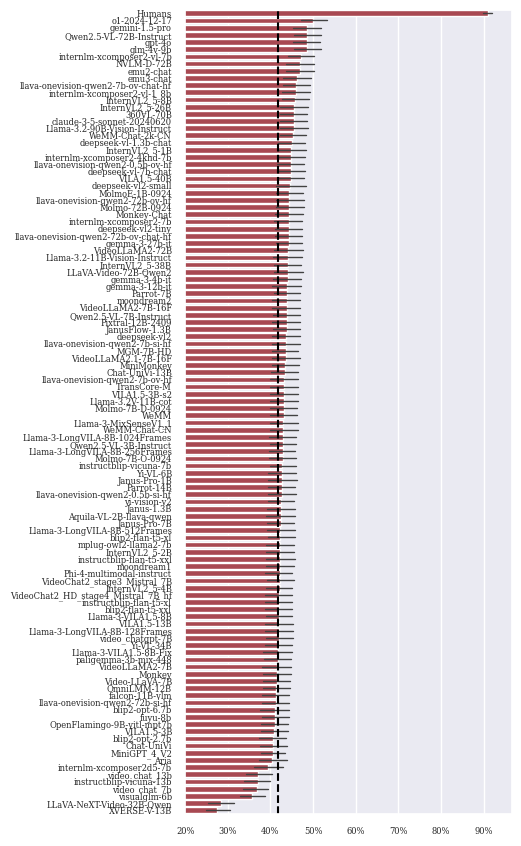

In [17]:
# Collapse across Candidates, Proximity, and Angle
result_df_t = result_df[ (result_df["Part"] != 'p1') & (result_df["Part"] != 'p2') ] # take the first round responese (where each stimulus is presented once)
mean_df = result_df_t.groupby(["Group"])['Accuracy'].mean().reset_index()
mean_df = mean_df.sort_values(by=["Accuracy"], ascending=False)

plt.figure(figsize=(5.5, 8.5)) # textheight=9inch, width=5.5inch
plt.tick_params(axis='both', which='major', labelsize=6)

order = mean_df["Group"].tolist()
logger.info(f"number of groups: {len(order)}")
g = sns.barplot(
    data=result_df_t,
    y="Group",
    x="Accuracy",
    order=order,
    errorbar=('ci', 95),
    err_kws={'linewidth': 1},
    formatter= None,
    color=colors[0],
)
#g.set_xscale("log")
baseline = get_baseline(stimuli_df)
plt.axvline(baseline, color='black', linestyle='dashed')
plt.ylabel("")
plt.xlabel("")
plt.xlim(left=0.20)
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y * 100:.0f}%"))
    
plt.subplots_adjust(left=0.376, bottom=0.034, right=0.97, top=0.98, wspace=0.09, hspace=0.211)

/Users/zory/miniforge3/envs/py310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/zory/miniforge3/envs/py310/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


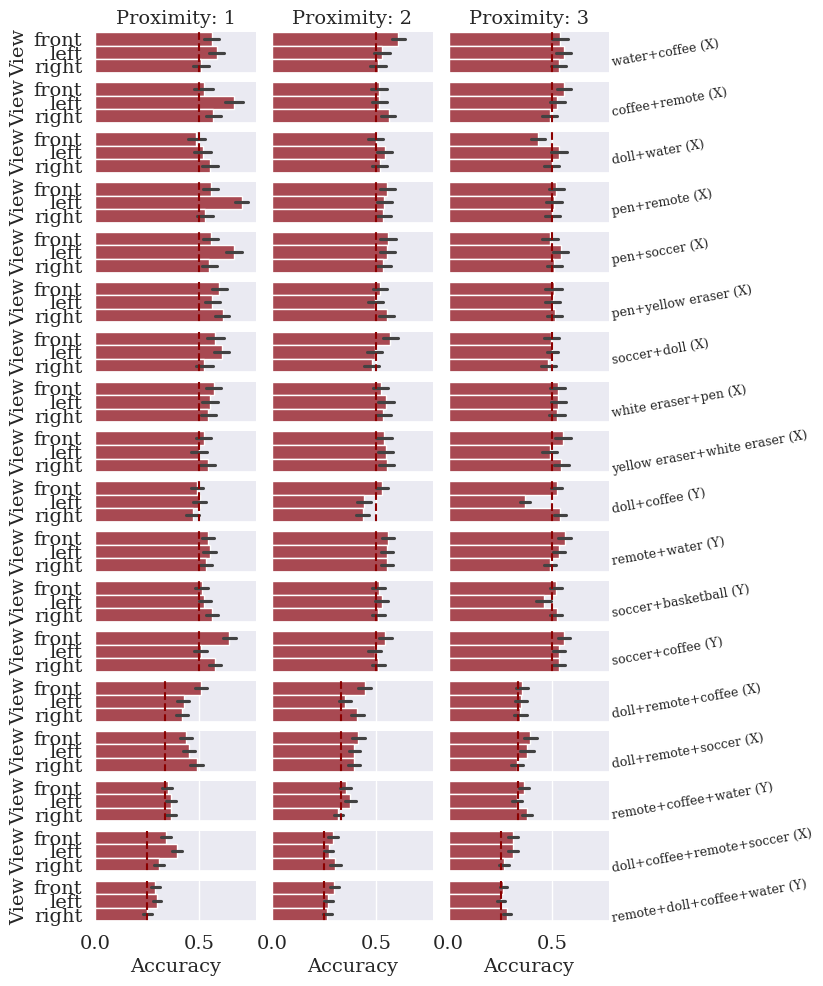

In [18]:
format_column = "Formatted_Candidates_Full"
row_names = sorted_candidates_full
height = 0.55
aspect = 5

g = sns.FacetGrid(result_df, row=format_column, row_order=row_names, col="Proximity", margin_titles=True, height=height, aspect=aspect)
g.map_dataframe(
    sns.barplot,
    y="Angle", x="Accuracy", order=["front", "left", "right"],
    errorbar=('ci', 95),
    orient="h", width=1,
    color=colors[0],
)
g.set_axis_labels("Accuracy", "View", fontsize=14)
g.set_titles(row_template="", col_template="Proximity: {col_name}", size=14)
for ax, row_name in zip(g.axes[:, 2], g.row_names):
    ax.annotate(
        row_name,
        xy=(1.01, 0.5),  # Move text further left for visibility
        xycoords='axes fraction',
        ha='left',
        va='center',
        fontsize=9,
        rotation=10
    )
for (row_val, col_val), ax in g.axes_dict.items():
    baseline = 1 / len(row_val.split("+"))
    ax.axvline(baseline, color='darkred', linestyle='dashed')
plt.subplots_adjust(left=0.126, bottom=0.064, right=0.749, top=0.962, wspace=0.099, hspace=0.226)


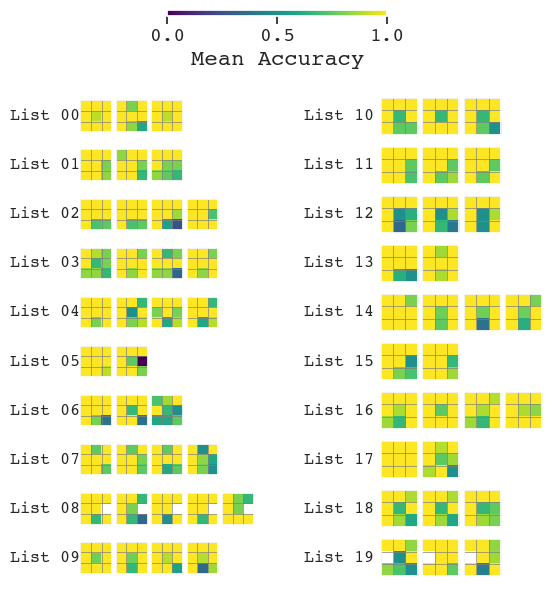

In [19]:
config_plot_style("Courier")

# Define angles and proximities for indexing
angles = ["front", "left", "right"]
proximities = [1, 2, 3]

# Filter for human data
human_df = result_df[result_df['GroupKind'] == "Humans"]

# Create figure with appropriate size
fig = plt.figure(figsize=(5.5, 6))

# Setup colormap and add colorbar at the top
cmap = plt.cm.viridis.copy()
# Make the colormap handle missing values (white)
cmap.set_bad('white', 1.0)
cbar_ax = fig.add_axes([0.3, 0.95, 0.4, 0.01])
mappable = plt.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=cmap)
cbar = plt.colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Mean Accuracy')

# Process and organize participant data by list_id
list_data = {}
for list_id in human_df['list_id'].unique():
    participants = []
    for p_id in human_df[human_df['list_id'] == list_id]['Participant_ID'].unique():
        p_data = human_df[(human_df['list_id'] == list_id) & 
                            (human_df['Participant_ID'] == p_id)]
        if len(p_data) == 45:  # Only include complete participant data
            # Pre-calculate accuracy matrices for efficiency
            # Create a masked array to handle missing data properly
            acc_matrix = np.ma.masked_all((len(proximities), len(angles)))
            for p_i, prox in enumerate(proximities):
                for a_i, ang in enumerate(angles):
                    subset = p_data[(p_data['Proximity'] == prox) & (p_data['Angle'] == ang)]
                    if not subset.empty:
                        acc_matrix[p_i, a_i] = subset['Accuracy'].mean()
                    # If no data, it remains masked
            
            participants.append({
                'id': p_id,
                'acc_matrix': acc_matrix
            })
    
    if participants:  # Only include lists with valid participants
        list_data[list_id] = participants

# Organize lists for left (<10) and right (≥10) columns with proper alignment
left_ids = sorted([id for id in list_data.keys() if id < 10])
right_ids = sorted([id for id in list_data.keys() if id >= 10])

# Find the maximum number of rows needed (largest index on either side)
max_row_idx = max(max(left_ids) if left_ids else 0,
                    max([id - 10 for id in right_ids]) if right_ids else 0) + 1

# Find the maximum number of participants in any list
max_participants_left = max([len(list_data[id]) for id in left_ids]) if left_ids else 0
max_participants_right = max([len(list_data[id]) for id in right_ids]) if right_ids else 0

# Create layout grid
outer_gs = gridspec.GridSpec(1, 2, figure=fig, width_ratios=[1, 1], wspace=0.2)

left_gs = gridspec.GridSpecFromSubplotSpec(
    max_row_idx, max_participants_left + 1,  # +1 for the list label
    subplot_spec=outer_gs[0, 0],
    width_ratios=[1] + [0.5] * max_participants_left,
    wspace=0.1, hspace=0.1
)

right_gs = gridspec.GridSpecFromSubplotSpec(
    max_row_idx, max_participants_right + 1,  # +1 for the list label
    subplot_spec=outer_gs[0, 1],
    width_ratios=[1] + [0.5] * max_participants_right,
    wspace=0.1, hspace=0.1
)

# Helper function to plot a single list's data
def plot_list_data(row_idx, list_id, gs, max_participants):
    if list_id not in list_data:
        return  # Skip if no data for this list_id
    
    # Add list label
    ax_label = fig.add_subplot(gs[row_idx, 0])
    ax_label.text(0.5, 0.5, f"List {list_id:02d}", 
                fontsize=12, ha='center', va='center')
    ax_label.axis('off')
    
    # Plot participant matrices
    participants = list_data[list_id]
    for p_idx, participant in enumerate(participants):
        if p_idx >= max_participants:
            break  # Don't exceed grid capacity
        
        p_ax = fig.add_subplot(gs[row_idx, p_idx + 1])
        # Use the masked array with our custom colormap
        p_ax.imshow(participant['acc_matrix'], cmap=cmap, vmin=0, vmax=1, aspect='equal')
        
        # Add grid lines
        p_ax.set_xticks(np.arange(-0.5, len(angles), 1), minor=True)
        p_ax.set_yticks(np.arange(-0.5, len(proximities), 1), minor=True)
        p_ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.5)
        p_ax.grid(which='major', visible=False)
        p_ax.set_xticks([])
        p_ax.set_yticks([])
    
    # Fill empty participant slots
    for p_idx in range(len(participants), max_participants):
        ax = fig.add_subplot(gs[row_idx, p_idx + 1])
        ax.axis('off')

# Process all rows for both columns
for row_idx in range(max_row_idx):
    # Left column (list_id = row_idx)
    plot_list_data(row_idx, row_idx, left_gs, max_participants_left)
    
    # Right column (list_id = row_idx + 10)
    plot_list_data(row_idx, row_idx + 10, right_gs, max_participants_right)

plt.subplots_adjust(left=0.02, bottom=0.01, right=0.982, top=0.82)
config_plot_style()  # restore default style


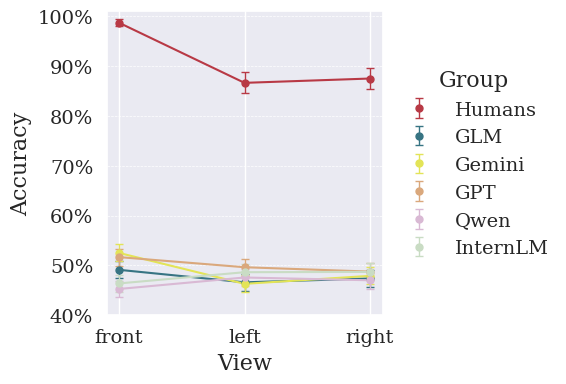

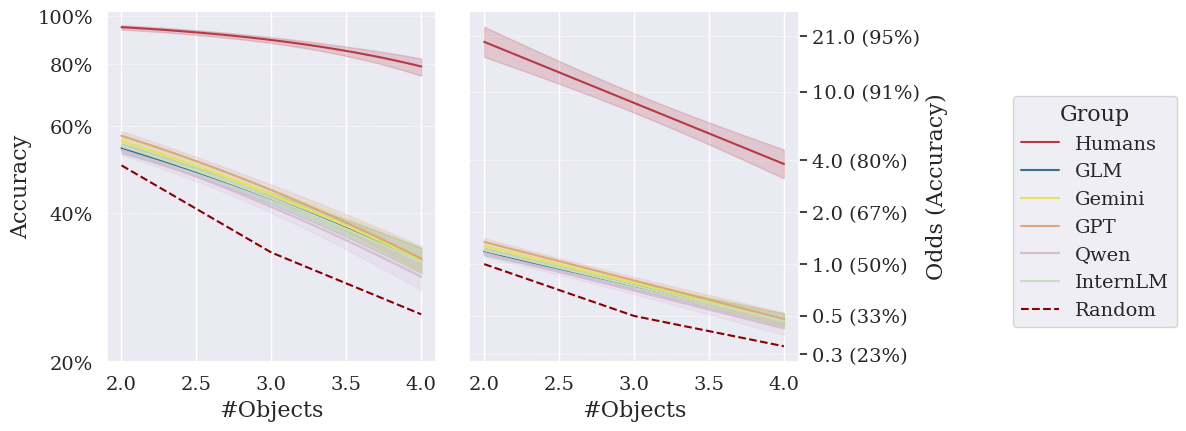

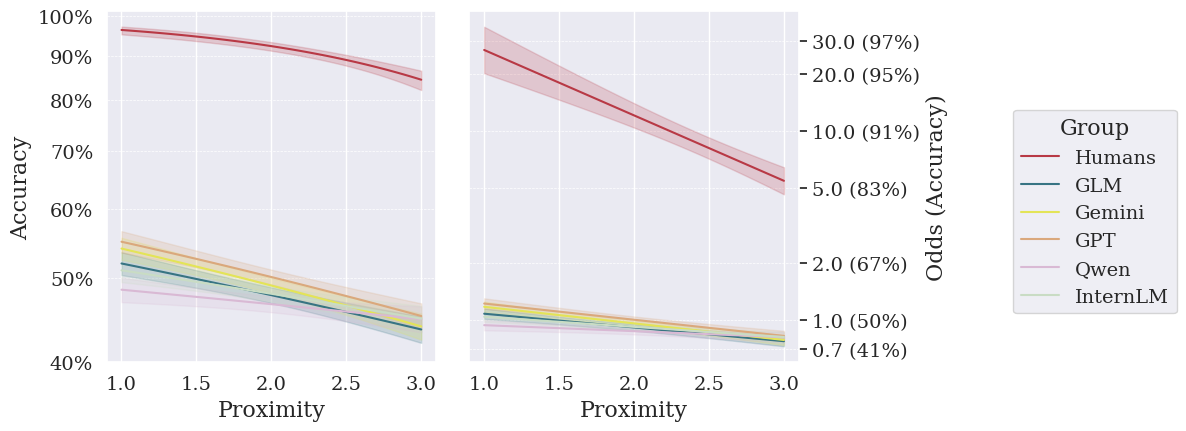

In [20]:
# draw scatter plot (with CI) of Angle vs Accuracy for each group
plt.figure(figsize=(6, 4))
for i, group in enumerate(GROUP_LIST):
    group_df = result_df[result_df["Group"] == group].copy()
    means = group_df.groupby("Angle")["Accuracy"].mean().reset_index()
    stds = group_df.groupby("Angle")["Accuracy"].std().reset_index()
    n = group_df.groupby("Angle")["Accuracy"].count().reset_index()
    plt.plot(means["Angle"], means["Accuracy"], color=colors[i], linewidth=1.5)
    plt.errorbar(
        means["Angle"], 
        means["Accuracy"], 
        yerr=1.96 * stds["Accuracy"] / np.sqrt(n["Accuracy"]), 
        fmt='o', 
        color=colors[i], 
        label=api_to_name.get(group, group), 
        capsize=3, 
        elinewidth=1, 
        markersize=5
    )
    
plt.xlabel("View")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.01)
plt.yticks(np.arange(0.4, 1.01, 0.1))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y * 100:.0f}%"))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
plt.grid(True, which="major", axis='y', linestyle='--', linewidth=0.5) # Add grid for readability
plt.legend(
    title="Group", 
    loc="center left", 
    bbox_to_anchor=(1., 0.5),
    ncol=1, frameon=False, 
    fontsize=SMALL_SIZE, title_fontsize=MEDIUM_SIZE
)
plt.subplots_adjust(left=0.19, bottom=0.19, right=0.65, top=0.95, wspace=0.09, hspace=0.211)
plt.show()

for VAR in ["n_candidates", "Proximity"]:
    display_VAR = VAR.capitalize() if VAR != "n_candidates" else "#Objects"

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharex=True) # 1 row, 2 columns
    ax1, ax2 = axes[0], axes[1] # Unpack axes
    handles, labels = [], [] # To store legend items

    for i, group in enumerate(GROUP_LIST):
        color = colors[i]
        group_df = result_df[result_df["Group"] == group].copy()
        group_label = api_to_name.get(group, group) # Use mapping or group name

        X = group_df[[VAR]]
        X = sm.add_constant(X)
        y = group_df["Accuracy"].astype(float)
        logit_model = sm.Logit(y, X).fit(disp=0)
        x_min = group_df[VAR].min()
        x_max = group_df[VAR].max()
        x_new = np.linspace(x_min, x_max, 50)
        X_new = sm.add_constant(x_new)
        
        # Calculate predictions and confidence intervals on logit scale
        y_pred_logit = np.dot(X_new, logit_model.params)
        cov_params = logit_model.cov_params()
        design_matrix_pred = X_new
        var_pred = np.diag(np.dot(design_matrix_pred, np.dot(cov_params, design_matrix_pred.T)))
        se_line = np.sqrt(var_pred)
        ci_lower_logit = y_pred_logit - 1.96 * se_line
        ci_upper_logit = y_pred_logit + 1.96 * se_line
        
        # Transform logit predictions to probabilities for ax1
        y_pred_prob = 1 / (1 + np.exp(-y_pred_logit))
        ci_lower_prob = 1 / (1 + np.exp(-ci_lower_logit))
        ci_upper_prob = 1 / (1 + np.exp(-ci_upper_logit))
        
        # Plot on ax1 (probability scale)
        ax1.plot(x_new, y_pred_prob, color=color, label=group_label, linewidth=1.5)
        ax1.fill_between(x_new, ci_lower_prob, ci_upper_prob, color=color, alpha=0.2)
        means = group_df.groupby(VAR)["Accuracy"].mean().reset_index()
        #ax1.scatter(means[VAR], means["Accuracy"], color=color, s=50, zorder=3)
        
        # Plot on ax2 (logit scale)
        y_pred_odds = np.exp(y_pred_logit)
        ci_lower_odds = np.exp(ci_lower_logit)
        ci_upper_odds = np.exp(ci_upper_logit)
        ax2.plot(x_new, y_pred_odds, color=color, label=group_label, linewidth=1.5)
        ax2.fill_between(x_new, ci_lower_odds, ci_upper_odds, color=color, alpha=0.2)
        #odds = means["Accuracy"] / (1 - means["Accuracy"])
        #ax2.scatter(means[VAR], odds, color=color, s=50, zorder=3)

    # --- Plot Baselines ---
    if VAR == "n_candidates":
        baseline_x = np.array([2, 3, 4])
        baseline_y = 1 / baseline_x
        baseline_odds = baseline_y / (1 - baseline_y)
        ax1.plot(baseline_x, baseline_y, color='darkred', linestyle='dashed', label='Random')
        ax2.plot(baseline_x, baseline_odds, color='darkred', linestyle='dashed', label='Random')

    # --- Axis 1 Formatting ---
    ax1.set_xlabel(display_VAR)
    ax1.set_ylabel("Accuracy")
    ax1.set_yscale('log')
    if VAR == "n_candidates":
        ax1.set_yticks(np.arange(0.2, 1.01, 0.2))
    else:
        ax1.set_yticks(np.arange(0.4, 1.01, 0.1))
    ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y * 100:.0f}%"))
    ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax1.grid(True, which="major", axis='y', linestyle='--', linewidth=0.5) # Add grid for readability

    # --- Axis 2 Formatting ---
    ax2.set_xlabel(display_VAR)
    ax2.set_yscale('log')
    ax2.set_ylabel("Odds (Accuracy)")
    yticks = [0.3, 0.5, 1, 2, 4, 10, 21] if VAR == "n_candidates" else [0.7, 1, 2, 5, 10, 20, 30]
    ax2.set_yticks(yticks); ax2.yaxis.set_minor_locator(ticker.FixedLocator(yticks))
    ax2.yaxis.set_label_position("right") # Move label to right
    ax2.yaxis.tick_right() # Move ticks to right
    ax2.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda y, _: f"{y:.1f} ({(y/(1+y)*100):.0f}%)") # Show logit and acc in %
    )
    ax2.grid(True, which="major", axis='y', linestyle='--', linewidth=0.5) # Add grid

    # --- Common Legend ---
    # Get handles and labels from one axis (they should be the same)
    handles, labels = ax1.get_legend_handles_labels()
    # Create a unique list of labels and corresponding handles
    unique_labels = {}
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels[label] = handle
    # Place legend outside the plot area to the right
    fig.legend(
        unique_labels.values(), 
        unique_labels.keys(),
        title="Group", 
        loc="center right", 
        bbox_to_anchor=(1., .5),
        ncol=1, frameon=True, 
        fontsize=SMALL_SIZE, title_fontsize=MEDIUM_SIZE
    )
    plt.subplots_adjust(left=0.1, bottom=0.165, right=0.677, top=0.946, wspace=0.1) # Increased right margin, reduced wspace
    plt.show()

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Accuracy         Pseudo R-squared: 0.012     
Date:               2025-05-22 21:36 AIC:              1751.5488 
No. Observations:   2925             BIC:              1763.5109 
Df Model:           1                Log-Likelihood:   -873.77   
Df Residuals:       2923             LL-Null:          -884.34   
Converged:          1.0000           LLR p-value:      4.2683e-06
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const              2.5085   0.0832 30.1493 0.0000  2.3454  2.6716
Response_Time_s   -0.0433   0.0114 -3.8005 0.0001 -0.0656 -0.0209
 

P-value: const              1.094736e-199
Response_Time_s     1.444324e-04
Name: P>|z|, dtype: floa

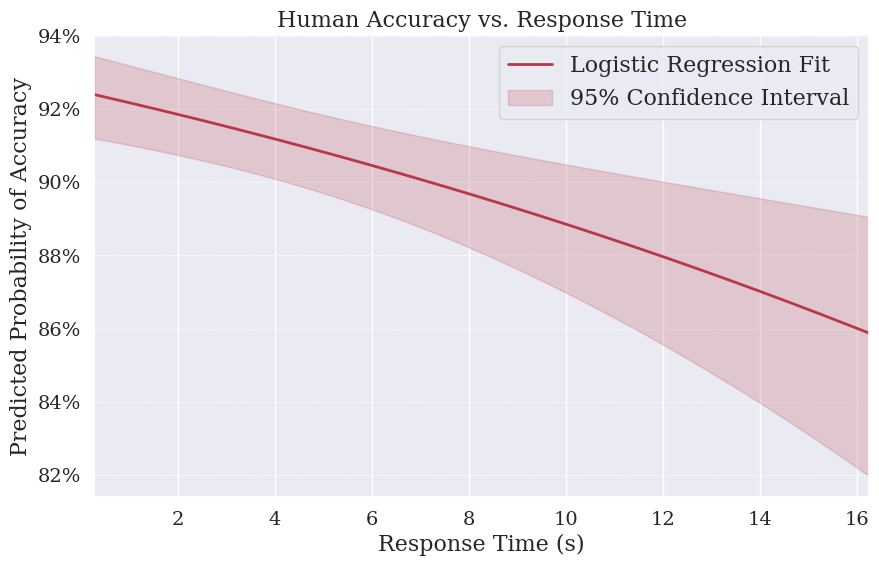

In [17]:
human_df = result_df[result_df["GroupKind"] == "Humans"].copy()
human_df['Response_Time_s'] = human_df['Response_Time'] / 1000.0 # Convert milliseconds to seconds

# Define the independent variable (X) and dependent variable (y)
VAR = 'Response_Time_s'
X_data = human_df[VAR]
X_sm = sm.add_constant(X_data) # Add an intercept term to the model
y_data = human_df['Accuracy']

# Fit the logistic regression model
logit_model = sm.Logit(y_data, X_sm).fit(disp=0) # disp=0 suppresses optimization output

# Generate a sequence of response times for prediction
x_min = human_df[VAR].min()
x_max = human_df[VAR].max()

# Cap the maximum response time for plotting to avoid overly long tails (e.g., 99th percentile or a fixed value)
plot_x_max = human_df[VAR].quantile(0.99) 
if plot_x_max > 30: # Further cap if 99th percentile is still very high
    plot_x_max = 30.0
if plot_x_max <= x_min: # Ensure plot_x_max is greater than x_min
    plot_x_max = x_max

x_new = np.linspace(x_min, plot_x_max, 200) # 200 points for a smooth curve
X_new_sm = sm.add_constant(x_new)


p_values = logit_model.summary2().tables[1]['P>|z|']
print(logit_model.summary2(), '\n\nP-value:', p_values )

# Calculate predictions and confidence intervals on logit scale
y_pred_logit = np.dot(X_new_sm, logit_model.params)
cov_params = logit_model.cov_params()
var_pred = np.diag(np.dot(X_new_sm, np.dot(cov_params, X_new_sm.T)))
se_line = np.sqrt(var_pred)
ci_lower_logit = y_pred_logit - 1.96 * se_line
ci_upper_logit = y_pred_logit + 1.96 * se_line

# Transform logit predictions to probabilities
y_pred_prob = 1 / (1 + np.exp(-y_pred_logit))
ci_lower_prob = 1 / (1 + np.exp(-ci_lower_logit))
ci_upper_prob = 1 / (1 + np.exp(-ci_upper_logit))

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the logistic regression curve (using a color from the predefined 'colors' list if available)
ax1.plot(x_new, y_pred_prob, label='Logistic Regression Fit', color=colors[0] if 'colors' in locals() else 'blue', linewidth=2)
# Plot the confidence interval
ax1.fill_between(x_new, ci_lower_prob, ci_upper_prob, color=colors[0] if 'colors' in locals() else 'blue', alpha=0.2, label='95% Confidence Interval')

# --- Axis 1 Formatting ---
ax1.set_xlabel("Response Time (s)")
ax1.set_ylabel("Predicted Probability of Accuracy")
ax1.set_title('Human Accuracy vs. Response Time', fontsize=16)
ax1.legend()
ax1.grid(True, which="major", axis='y', linestyle='--', linewidth=0.5)

# Set y-axis to show percentages and define ticks/limits
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y * 100:.0f}%"))
#ax1.set_yticks(np.arange(0.4, 1.01, 0.1))
#ax1.set_ylim(0.4, 1.01)
ax1.set_xlim(x_min, plot_x_max)

# Save plot (ensure 'plots' directory exists)
#import os
#if not os.path.exists('plots'):
#    os.makedirs('plots')
#plt.savefig(pjoin('plots', 'human_accuracy_vs_rt.pdf'), bbox_inches='tight')
plt.show()